<a href="https://colab.research.google.com/github/don05050505/don05050505/blob/main/ThoraricSur20230803.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ThoraricSurgery3.csv to ThoraricSurgery3.csv


In [6]:
class ThoraricANN(tf.keras.Model):
    def __init__(self):

        super(ThoraricANN, self).__init__()

        self.hidden1 = tf.keras.layers.Dense(128,
                                            activation='relu',
                                            kernel_initializer=self.weight_initialization(),
                                            bias_initializer=self.weight_initialization()
                                            )
        self.drop1 = tf.keras.layers.Dropout(0.5)

        self.hidden2 = tf.keras.layers.Dense(64,
                                            activation='relu',
                                            kernel_initializer=self.weight_initialization(),
                                            bias_initializer=self.weight_initialization()
                                            )
        self.drop2 = tf.keras.layers.Dropout(0.5)

        self.hidden3 = tf.keras.layers.Dense(32,
                                            activation='relu',
                                            kernel_initializer=self.weight_initialization(),
                                            bias_initializer=self.weight_initialization()
                                            )
        self.drop3 = tf.keras.layers.Dropout(0.5)

        self.outPut = tf.keras.layers.Dense(2,
                                            activation=None,
                                            kernel_initializer=self.weight_initialization(),
                                            bias_initializer=self.weight_initialization()
                                            )

    def weight_initialization(self):
        return tf.keras.initializers.RandomNormal(mean=0., stddev=1., seed=None)

    def call(self, x, flag):
        print(x.shape)
        y1 = self.hidden1(x)
        d1 = self.drop1(y1, training=flag)
        y2 = self.hidden2(d1)
        d2 = self.drop2(y2, training=flag)
        y3 = self.hidden3(d2)
        d3 = self.drop3(y3, training=flag)
        logits = self.outPut(d3)
        sy = tf.nn.softmax(logits)
        return logits, sy


In [7]:
@tf.function
def cross_entropy_loss(logits, y):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    return loss

learningRate = 0.01
optimizer = tf.optimizers.Adam(learningRate)

@tf.function
def backward(model, x, y, flag):
    with tf.GradientTape() as gt:
        logits, sy = model(x, flag)
        loss = cross_entropy_loss(logits, y)
    grads = gt.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def accuracy(predY, y):
    correction = tf.equal(tf.argmax(predY, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(correction, tf.float32))
    return acc


def train_learning(epochs, frequence, trainDataIter, model, XTest, yTest, flag):
    y_loss = []
    for epoch in range(epochs):
        bx, by = next(trainDataIter)
        loss = backward(model, bx, by, flag)
        y_loss.append(loss)
        if epoch % frequence == 0:
            predY, sy = model(bx, flag)
            acc = accuracy(predY, by)
            print(f"Epoch: {epoch+1} ===> Loss: {loss}, accuracy: {acc}")
    predY, sy = model(XTest, False)
    acc = accuracy(predY, yTest)
    print(f"Accuracy: {acc}")

    return y_loss

(470, 17)
(329, 16)
(100, 16)
(100, 16)
(100, 16)
Epoch: 1 ===> Loss: 891.6177368164062, accuracy: 0.46000000834465027
(100, 16)
Epoch: 151 ===> Loss: 4.446937084197998, accuracy: 0.75
(100, 16)
Epoch: 301 ===> Loss: 4.384564399719238, accuracy: 0.8199999928474426
(100, 16)
Epoch: 451 ===> Loss: 0.5751767158508301, accuracy: 0.7900000214576721
(100, 16)
Epoch: 601 ===> Loss: 0.7591394782066345, accuracy: 0.8600000143051147
(100, 16)
Epoch: 751 ===> Loss: 0.9660115838050842, accuracy: 0.8100000023841858
(100, 16)
Epoch: 901 ===> Loss: 0.7298775315284729, accuracy: 0.8100000023841858
(141, 16)
Accuracy: 0.8723404407501221


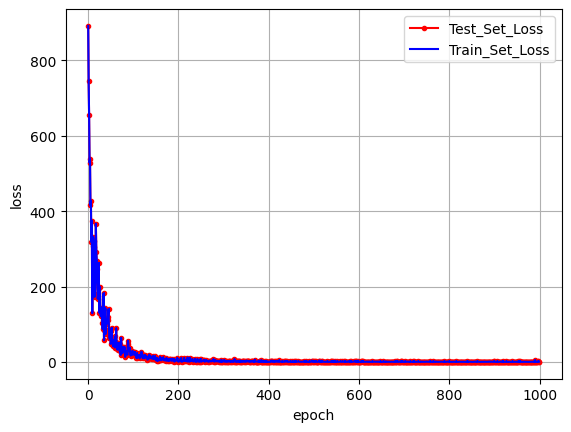

In [8]:
if __name__ == "__main__":
    df = pd.read_csv("ThoraricSurgery3.csv")
    print(df.shape)
    X = df[['a','b','c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']]
    y = df[['label']]
    X = X.to_numpy()

    X = (np.max(X, axis=0)-X) / (np.max(X, axis=0)-np.min(X, axis=0))
    y = y.to_numpy()
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=2500)
    XTrain, XTest = XTrain.astype('float32'), XTest.astype('float32')
    yTrain = tf.squeeze(tf.one_hot(yTrain, 2))
    yTest = tf.squeeze(tf.one_hot(yTest, 2))
    print(XTrain.shape)
    trainData = tf.data.Dataset.from_tensor_slices((XTrain, yTrain))
    trainData = trainData.repeat().shuffle(XTrain.shape[0]).batch(100)

    trainDataIter = iter(trainData)

    epochs = 1000
    frequence = 150
    flag = True

    model = ThoraricANN()
    y_loss = train_learning(epochs, frequence, trainDataIter, model, XTest, yTest, flag)

    x_len = np.arange(len(y_loss))
    plt.plot(x_len, y_loss, marker='.', c='red', label='Test_Set_Loss')
    plt.plot(x_len, y_loss, marker=',', c='blue', label='Train_Set_Loss')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()